In [3]:
from elasticsearch import Elasticsearch
from elasticsearch_dsl import connections
client = Elasticsearch()

connections.configure(
    default={'hosts': 'localhost'},
)

### Zdefiniuj w ES indeks do przechowywania orzeczeń sądów oraz analizator zawierający następujące elementy (tekst w języku polskim): standardowy tokenizer filtr lematyzujący oparty o morfologika 


```json
PUT judgments
{
  "settings": {
    "analysis": {
      "analyzer": {
        "polish_analyzer": { 
          "tokenizer": "standard",
          "filter": [
            "morfologik_stem"
          ],
          "type": "custom"
        }
      }
    }
  },
  "mappings": {
    "doc": {
      "properties": {
        "content": {
          "type": "text",
          "analyzer": "polish_analyzer"
        },
        "judgmentDate": {
          "type": "date",
          "format": "yyyy-MM-dd"
        },
        "signature": {
          "type": "keyword"
        },
        "judges": {
          "type": "keyword"
        }
      }
    }
  }
}
```

In [4]:
from elasticsearch_dsl import analyzer
analyzer = analyzer(
    'polish_analyzer',
    tokenizer="standard",
    filter=["morfologik_stem"],
)

In [14]:
from elasticsearch_dsl import DocType, Text, Date, Keyword, Nested, InnerDoc, Index
judgments = Index('judgments')
judgments.analyzer(analyzer)

class Judge(InnerDoc):
    name = Text(analyzer=analyzer)

@judgments.doc_type
class Judgment(DocType):
    content = Text(analyzer='polish_analyzer')
    judgment_date = Date()
    signature = Keyword()
    judges = Nested(Judge)

print(judgments.to_dict())    
judgments.create()

{'mappings': {'doc': {'properties': {'content': {'analyzer': 'polish_analyzer', 'type': 'text'}, 'judgment_date': {'type': 'date'}, 'signature': {'type': 'keyword'}, 'judges': {'properties': {'name': {'analyzer': 'polish_analyzer', 'type': 'text'}}, 'type': 'nested'}}}}, 'settings': {'analysis': {'analyzer': {'polish_analyzer': {'tokenizer': 'standard', 'filter': ['morfologik_stem'], 'type': 'custom'}}}}}


### Załaduj dane z wybranego roku do ESa

In [123]:
# configs 
DATA_DIR = "/run/media/maciej/Nowy/data/json/"
CHOSEN_YEAR = str(2011)
FILE_LIST = 'files.pickle'


In [124]:
import json
import os
import pickle

from tqdm import tqdm

def load_data():    
    files = pickle.load(open(FILE_LIST, 'rb'))
    files = os.listdir(DATA_DIR)
    results = []
    for file in tqdm(files):
        if file.startswith("judgment"):
            file_path = os.path.join(DATA_DIR, file)

            with open(file_path, 'r') as f:
                data = json.load(f)
                judgments = [x for x in data["items"] if x["judgmentDate"].startswith(CHOSEN_YEAR)]

            for judgment in judgments:
                Judgment(
                    content=judgment['textContent'],
                    judgment_date=judgment['judgmentDate'],
                    signature=judgment['id'],
                    judge=[Judge(name=judge['name']) for judge in judgment['judges']],
                ).save()

load_data()

100%|██████████| 3192/3192 [03:45<00:00, 14.13it/s]


[]

### Znajdź liczbę orzeczeń, w których występuje słowo szkoda.
```
GET judgments/_search 
{
  "query": {
    "match": {
      "content": "szkoda"
    }
  }, 
  "explain": true
}
```

In [53]:
s = Judgment.search().extra(explain=True)
query_content = s.query("match", content="szkoda")
print(query_content.to_dict())
szkoda_occurences = query_content.execute()

print(szkoda_occurences.hits.total)

{'query': {'match': {'content': 'szkoda'}}, 'explain': True}
1828


### Znajdź liczbę orzeczeń, w których występuje fraza trwały uszczerbek na zdrowiu, dokładnie w tej kolejności ale w dowolnej formie fleksyjnej.

```
GET judgments/_search
{
    "query": {
        "match_phrase": {
            "content": "trwały uszczerbek na zdrowiu"
        }
    }
}
```

In [54]:
from elasticsearch_dsl.query import MatchPhrase

m = MatchPhrase(
    content="trwały uszczerbek na zdrowie"
)
print(s.query(m).to_dict())
permanent_damage = s.query(m).execute()

{'query': {'match_phrase': {'content': 'trwały uszczerbek na zdrowie'}}, 'explain': True}


In [55]:
permanent_damage.hits.total

24

### Jak wyżej, ale z uwzględnieniem możliwości wystąpienia maksymalnie 2 dodatkowych słów pomiędzy dowolnymi elementami frazy.
```
GET /_search
{
    "query": {
        "span_near" : {
            "clauses" : [
                { "span_term" : { "content" : "trwały" } },
                { "span_term" : { "content" : "uszczerbek" } },
                { "span_term" : { "content" : "na" } },
                { "span_term" : { "content" : "zdrowiu" } }
            ],
            "slop" : 2,
            "in_order" : true
        }
    }
}
```

In [56]:
from elasticsearch_dsl.query import SpanNear
span = SpanNear(
    clauses=[
        {"span_term": {"content": "trwały"}},
        {"span_term": {"content": "uszczerbek"}},
        {"span_term": {"content": "na"}},
        {"span_term": {"content": "zdrowiu"}},
    ],
    slop=2,
    in_order=True,
)
print(s.query(span).to_dict())
permanent_damage_with_span = s.query(span).execute()

{'query': {'span_near': {'clauses': [{'span_term': {'content': 'trwały'}}, {'span_term': {'content': 'uszczerbek'}}, {'span_term': {'content': 'na'}}, {'span_term': {'content': 'zdrowiu'}}], 'slop': 2, 'in_order': True}}, 'explain': True}


In [172]:
permanent_damage_with_span.hits.total

0

In [63]:
m = {
    "match_phrase": {
        "content": {
            "query": "trwały uszczerbek na zdrowie",
            "slop": 2
        }
    }
}
print(s.query(m).to_dict())
permanent_damage_with_slop = s.query(m).execute()

{'query': {'match_phrase': {'content': {'query': 'trwały uszczerbek na zdrowie', 'slop': 2}}}, 'explain': True}


In [65]:
permanent_damage_with_slop.hits.total

24

### Określ 3 sędziów, którzy wydali największą liczbę orzeczeń w danym roku, wraz z liczbą wydanych orzeczeń.


In [182]:
query = Judgment.search()
query.aggs.bucket('most_active_judges', 'terms', field='judge.name.keyword', size=3)
response = query.execute()

In [184]:
for hit in response.aggregations.most_active_judges:
    print(hit)

{'key': 'Marta Romańska', 'doc_count': 229}
{'key': 'Grzegorz Misiurek', 'doc_count': 198}
{'key': 'Jan Górowski', 'doc_count': 174}


### Przedstaw histogram liczby orzeczeń w zależności od miesiąca.

```json
GET judgments/_search
{
  "size": 0,
  "aggs": {
    "judgments_by_month": {
      "date_histogram": {
        "field": "date",
        "interval": "month"
      }
    }
  }
}
```

In [13]:
query = Judgment.search()
query.aggs.bucket(
    'judgments_by_month',
    'date_histogram',
    field='judgment_date',
    interval='month',
)
response = query.execute()


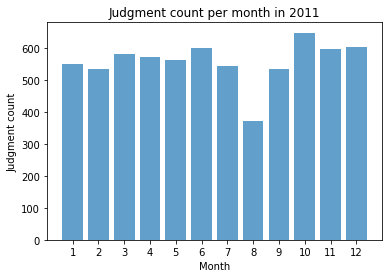

In [46]:
import matplotlib.pyplot as plt

buckets = response.aggregations.judgments_by_month['buckets']
doc_counts = [bucket.doc_count for bucket in buckets]    


plt.xticks(list(range(1,13)))
plt.bar(list(range(1,13)), doc_counts, align='center', alpha=0.7)
plt.xlabel('Month')

plt.ylabel('Judgment count')

plt.title('Judgment count per month in 2011')
plt.show()
